In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import time
import torchvision
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
from tqdm import tqdm
import random
import numpy as np
import cv2
from skimage.util import view_as_windows
from sklearn.feature_extraction import image as image_skl
from scipy.ndimage import rotate
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Creating Dataset

In [3]:
class CIFAR10LightnessColor(Dataset):
    def __init__(self, split='train', transform=None):
        if split == 'train':
            cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
        elif split == 'test':
            cifar_dataset = datasets.CIFAR10(root='./data', train=False, download=True)
        
        self.data = []
        self.labels = []
        self.transform = transform
        
        for i, (img, label) in enumerate(cifar_dataset):
            img_gray = rgb2gray(np.array(img)) # convert to lightness channel
            #img_gray = img_gray.unsqueeze(0).float()

            img_lab = rgb2lab(img)
            img_lab = (img_lab + 128) / 255
            img_ab = img_lab[:, :, 1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()

            self.data.append(img_gray)
            self.labels.append(img_ab)
        
        self.data = np.array(self.data)
        self.labels = np.array(self.labels)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]


        if self.transform:
            img = self.transform(img)
        
        return img, label

In [4]:
train_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(), # isto depois da erro no type dos dados, ver pq e corrigir
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = CIFAR10LightnessColor(split='train', transform=train_transform)

testset = CIFAR10LightnessColor(split='test', transform=test_transform)


batch_size = 32

trainloader = DataLoader(trainset, batch_size=batch_size)

testloader = DataLoader(testset, batch_size=batch_size)

Files already downloaded and verified


C:\Users\Frederico\AppData\Local\Temp\ipykernel_4028\61871531.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  self.labels = np.array(self.labels)
C:\Users\Frederico\AppData\Local\Temp\ipykernel_4028\61871531.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.labels = np.array(self.labels)


Files already downloaded and verified


In [5]:
# choose a picture at random
im_minibatch, label_minibatch = next(iter(testloader))
im, label = im_minibatch[0].cpu(), label_minibatch[0].cpu()

# store image size dimensions
image_size = tuple(im.shape)
label_size = tuple(label.shape)
print(image_size)
print(label_size)

(1, 32, 32)
(2, 32, 32)


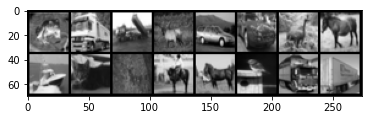

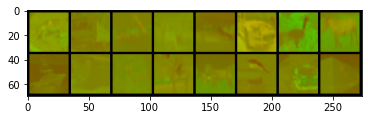

In [6]:
# function to show an image
def show(img, lab=False):
    npimg = img.numpy()
    if lab:
        rgb_img = np.concatenate([img, np.zeros((1, img.shape[1], img.shape[2]))], axis=0)
        plt.imshow(np.transpose(rgb_img, (1, 2, 0)))
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images

show(torchvision.utils.make_grid(images[0:16]))
# show labels
show(torchvision.utils.make_grid(labels[0:16]), lab=True)

# meio estranho, n sei como imprimir direito a imagem so com cor


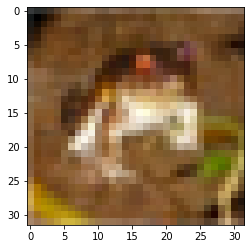

In [7]:
def to_rgb(grayscale_input, ab_input):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  plt.imshow(color_image)

# show image
to_rgb(images[0],labels[0])

## Model preparation

### Creating model

In [8]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [9]:
model = ColorizationNet()

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.to(device)

ColorizationNet(
  (midlevel_resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

### Training (run only if you want to train again, weights alredy saved)

In [10]:
# function for training the model given the model, dataset and weight directory where they are saved
#from sewar.full_ref import mse
#adicionar medida de semelhança entre imagens
def train_model(model, trainloader, testloader, weights_dir, num_epochs=50):
    start=time.time()
    
    
    for epoch in range(0,num_epochs):

        model.train()  # Put the network in train mode
        for i, (x_batch, y_batch) in enumerate(trainloader):
            x_batch, y_batch = x_batch.to(device).float(), y_batch.to(device)  # Move the data to the device that is used

            optimizer.zero_grad()  # Set all currenly stored gradients to zero 

            y_pred = model(x_batch)

            loss = criterion(y_pred, y_batch)

            loss.backward()

            optimizer.step()

            # Compute relevant metrics


            elapsed = time.time() - start  # Keep track of how much time has elapsed

            # Show progress every 20 batches 
            if not i % 20:
                print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item()}')

        correct_total = 0

        model.eval()  # Put the network in eval mode
        for i, (x_batch, y_batch) in enumerate(testloader):
            x_batch, y_batch = x_batch.to(device).float(), y_batch.to(device)  # Move the data to the device that is used

            y_pred = model(x_batch)

            loss = criterion(y_pred, y_batch)


        print(f'loss: {loss.item()}')

        # Save weights every 10 epochs
        if epoch%10==0:
            torch.save(model.state_dict(), f"./{weights_dir}/epoch-{epoch}_accuracy-{correct_total/len(testset)}.pth")

In [11]:
# delete the directory of weights if it already exists and then create it
if os.path.exists(os.path.join('weights')):
    shutil.rmtree(os.path.join('weights'))
!mkdir weights

In [12]:
train_model(model, trainloader, testloader, 'weights')

epoch: 0, time: 8.942s, loss: 0.6603198051452637
epoch: 0, time: 9.205s, loss: 0.009469041600823402
epoch: 0, time: 9.447s, loss: 0.009882893413305283
epoch: 0, time: 9.698s, loss: 0.005387725308537483
epoch: 0, time: 9.947s, loss: 0.0028982842341065407
epoch: 0, time: 10.211s, loss: 0.004202431067824364
epoch: 0, time: 10.474s, loss: 0.0038272389210760593
epoch: 0, time: 10.732s, loss: 0.0023971237242221832
epoch: 0, time: 10.972s, loss: 0.0024698541965335608
epoch: 0, time: 11.225s, loss: 0.0024865479208528996
epoch: 0, time: 11.469s, loss: 0.003852174151688814
epoch: 0, time: 11.728s, loss: 0.003279014490544796
epoch: 0, time: 11.987s, loss: 0.0034609565045684576
epoch: 0, time: 12.227s, loss: 0.002469882369041443
epoch: 0, time: 12.478s, loss: 0.002757534384727478
epoch: 0, time: 12.733s, loss: 0.004595005419105291
epoch: 0, time: 12.979s, loss: 0.002530199009925127
epoch: 0, time: 13.241s, loss: 0.0027431207709014416
epoch: 0, time: 13.499s, loss: 0.003138151252642274
epoch: 0, ti

### Load latest weights

In [13]:
# function for loaduing weights of a trained model
def load_weights(model, weights_dir):
    files = os.listdir(weights_dir)
    weight_paths = [os.path.join(weights_dir, basename) for basename in files]
    # get the latest file in the directory
    final_weight_file = os.path.basename(max(weight_paths, key=os.path.getctime))

    # first model needs to be loaded
    model = ColorizationNet()

    # fixes odd error when state_dict has prescript "model."" in keys
    state_dict = torch.load(os.path.join(weights_dir, final_weight_file), map_location=device)
    for key in list(state_dict.keys()):
        if key.startswith("model."):
            state_dict[key[6:]] = state_dict.pop(key)
    model.load_state_dict(state_dict)

    print('Loaded weights: ' + final_weight_file)
    
    return model

In [14]:
# load trained model weights for the original model
model_org = load_weights(model, 'weights')

Loaded weights: epoch-40_accuracy-0.0.pth


In [15]:
%%capture
model_org.to(device)
model_org.eval()

## Evaluation

In [16]:
def separate():
    print('-'*120)

In [17]:
def show(img, lab=False):
    npimg = img.numpy()
    if lab:
        rgb_img = np.concatenate([img, np.zeros((1, img.shape[1], img.shape[2]))], axis=0)
        plt.imshow(np.transpose(rgb_img, (1, 2, 0)))
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.show()

In [18]:
def to_rgb(grayscale_input, ab_input):
    '''Show/save rgb image from grayscale and ab channels
        Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
    plt.clf() # clear matplotlib 
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
    color_image = lab2rgb(color_image.astype(np.float64))
    plt.imshow(color_image)
    plt.show()
    return color_image

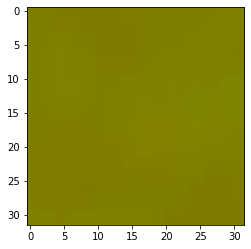

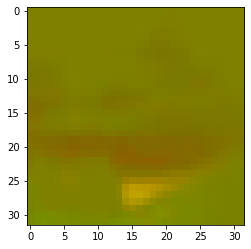

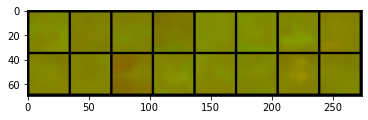

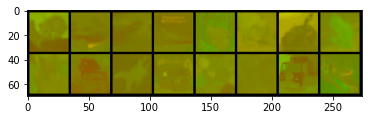

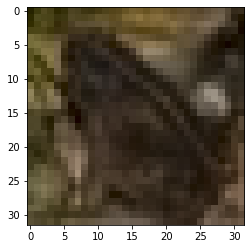

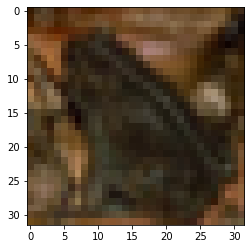

In [26]:
# function that visualizes how given model gives predictions based on a few examples
def show_examples(testloader, model):
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    
    images = images.to(device).float()
    labels = labels.to(device)
    outputs = model(images)

    # show images
    show(outputs[1].detach().cpu(), True)
    show(labels[1].detach().cpu(), True)
    show(torchvision.utils.make_grid(outputs[0:16].detach().cpu()), True)
    show(torchvision.utils.make_grid(labels[0:16].detach().cpu()), True)
    to_rgb(images[30].detach().cpu(), outputs[30].detach().cpu())
    to_rgb(images[30].detach().cpu(), labels[30].detach().cpu())

show_examples(testloader, model)